In [125]:
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
from config import api_key
import requests
import json
from datetime import datetime

In [126]:
tickers = ["AAPL", "GOOGL", "AMZN"]

dummy = pd.DataFrame(columns = ["ticker", "o", "c", "t"])

#create loop to run through URL & save info into lists
for name in tickers:
    base_url = f"https://api.polygon.io/v2/aggs/ticker/{name}/range/1/day/2012-01-01/2022-10-24?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    response = requests.get(base_url).json()
    datadata = pd.json_normalize(response["results"])
    datadata["ticker"] = name
    datadata = datadata[["ticker", "o", "c", "t"]]

#print(datadata)
    dummy = pd.concat([dummy,datadata])
dummy.columns=["ticker", "open", "close", "date"]

#pd.concat([dummy,datadata],axis=0)
print(dummy)


     ticker      open     close           date
0      AAPL   21.2457   21.2614  1351656000000
1      AAPL   21.3650   21.3050  1351742400000
2      AAPL   21.2818   20.6000  1351828800000
3      AAPL   20.8398   20.8793  1352091600000
4      AAPL   21.0796   20.8161  1352178000000
...     ...       ...       ...            ...
2508   AMZN  119.0600  116.3600  1666065600000
2509   AMZN  114.7100  115.0700  1666152000000
2510   AMZN  113.8300  115.2500  1666238400000
2511   AMZN  114.7920  119.3200  1666324800000
2512   AMZN  119.9800  119.8200  1666584000000

[7182 rows x 4 columns]


In [127]:
#convert date to datetime
dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7182 entries, 0 to 2512
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  7182 non-null   object 
 1   open    7182 non-null   float64
 2   close   7182 non-null   float64
 3   date    7182 non-null   object 
dtypes: float64(2), object(2)
memory usage: 280.5+ KB


In [128]:
#Convert unix to datetime & remove hours/miuntes
dummy['date'] = pd.to_datetime(dummy['date'],unit='ms')

dummy["date"] = pd.to_datetime(dummy["date"]).dt.date

dummy


,ticker,open,close,date
0,AAPL,21.2457,21.2614,2012-10-31
1,AAPL,21.3650,21.3050,2012-11-01
2,AAPL,21.2818,20.6000,2012-11-02
3,AAPL,20.8398,20.8793,2012-11-05
4,AAPL,21.0796,20.8161,2012-11-06
...,...,...,...,...
2508,AMZN,119.0600,116.3600,2022-10-18
2509,AMZN,114.7100,115.0700,2022-10-19
2510,AMZN,113.8300,115.2500,2022-10-20
2511,AMZN,114.7920,119.3200,2022-10-21


In [79]:
#Set date as index
#dummy=dummy.set_index('date')
#dummy

,ticker,open,close
date,,,
2012-10-31,AAPL,21.2457,21.2614
2012-11-01,AAPL,21.3650,21.3050
2012-11-02,AAPL,21.2818,20.6000
2012-11-05,AAPL,20.8398,20.8793
2012-11-06,AAPL,21.0796,20.8161
...,...,...,...
2022-10-18,AMZN,119.0600,116.3600
2022-10-19,AMZN,114.7100,115.0700
2022-10-20,AMZN,113.8300,115.2500


In [143]:
#Create copy of dummy
tickers_copy = dummy.copy(deep=True)
#delete
del tickers_copy["open"]
#tickers_copy
#Create copy of dummy for %change & $change
tickers_pctchange = tickers_copy.copy(deep=True)


#Divide dataframes into new dataframes by ticker
aapl_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AAPL"]
aapl_daily2 = pd.DataFrame(aapl_daily2)
#print(aapl_daily2.head())
amzn_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AMZN"]
amzn_daily2 = pd.DataFrame(amzn_daily2)
#print(amzn_daily2.head())
googl_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "GOOGL"]
googl_daily2 = pd.DataFrame(googl_daily2)
#print(googl_daily2.head())

#rename close as ticker to prepare to merge by date
aapl_daily2.rename(columns = {'close':'AAPL'}, inplace = True)
del aapl_daily2["ticker"]
amzn_daily2.rename(columns = {'close':'AMZN'}, inplace = True)
del amzn_daily2["ticker"]
googl_daily2.rename(columns = {'close':'GOOGL'}, inplace = True)
del googl_daily2["ticker"]

#make copy for prices 
aapl_prices = aapl_daily2.copy(deep=True)
amzn_prices = amzn_daily2.copy(deep=True)
googl_prices = googl_daily2.copy(deep=True)
#print(aapl_prices)

#make copy for $ changes
aapl_bch = aapl_daily2.copy(deep=True)
amzn_bch = amzn_daily2.copy(deep=True)
googl_bch = googl_daily2.copy(deep=True)
#print(googl_bch)

#calculate % change
aapl_daily2["AAPL"]=aapl_daily2["AAPL"].pct_change()*100
amzn_daily2["AMZN"]=amzn_daily2["AMZN"].pct_change()*100
googl_daily2["GOOGL"]=googl_daily2["GOOGL"].pct_change()*100



In [146]:
#merge tables % change
merge_pctchange = aapl_daily2.merge(amzn_daily2, on='date', how='left')
merge_pctchange = merge_pctchange.merge(googl_daily2, on="date", how="left")
#merge_pctchange.head()

#merge tables prices 
merge_prices = aapl_prices.merge(amzn_prices, on='date', how='left')
merge_prices = merge_prices.merge(googl_prices, on="date", how="left")
merge_prices

#merge tables $change
merge_bch = aapl_bch.merge(amzn_bch, on='date', how='left')
merge_bch = merge_bch.merge(googl_bch, on="date", how="left")
merge_bch.head()

,AAPL,date,AMZN,GOOGL
0,21.2614,2012-10-31,11.6447,NaN
1,21.3050,2012-11-01,11.6070,NaN
2,20.6000,2012-11-02,11.6211,NaN
3,20.8793,2012-11-05,11.7165,NaN
4,20.8161,2012-11-06,11.8780,NaN


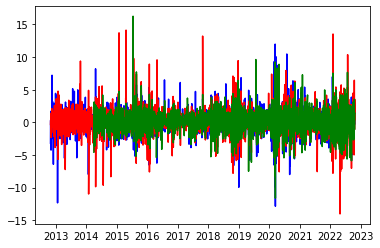

In [132]:
aapl_plot, = plt.plot(merge_pctchange["date"], merge_pctchange["AAPL"], color="blue", label="AAPL" )
amzn, = plt.plot(merge_pctchange["date"], merge_pctchange["AMZN"], color="red", label="AMZN" )
googl, = plt.plot(merge_pctchange["date"], merge_pctchange["GOOGL"], color="green", label="GOOGL" )
plt.show()

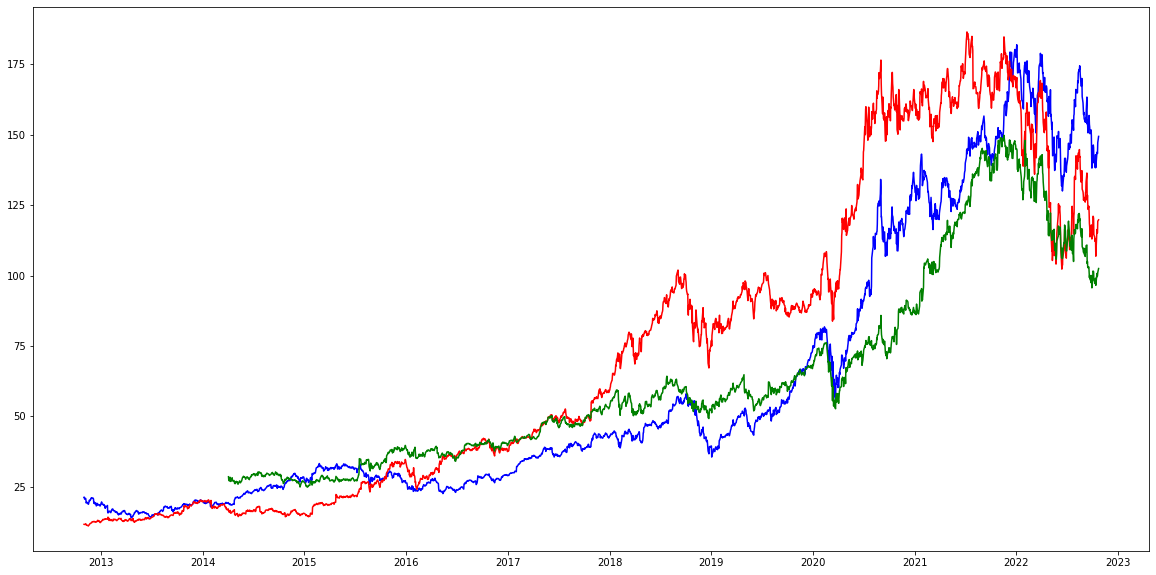

In [152]:
plt.figure(figsize=(20,10))
aapl_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AAPL"], color='blue', label="Sine")
amzn_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AMZN"], color='red', label="Sine")
googl_daily_chart, = plt.plot(merge_bch["date"], merge_bch["GOOGL"], color='green', label="Sine")

In [80]:
#Divide dataframes into new dataframes by ticker
aapl_daily = dummy[dummy["ticker"] == "AAPL"]
aapl_daily = pd.DataFrame(aapl_daily)
print(aapl_daily.head())
amzn_daily = dummy[dummy["ticker"] == "AMZN"]
amzn_daily = pd.DataFrame(amzn_daily)
print(amzn_daily.head())
googl_daily = dummy[dummy["ticker"] == "GOOGL"]
googl_daily = pd.DataFrame(googl_daily)
print(googl_daily.head())

           ticker     open    close
date                               
2012-10-31   AAPL  21.2457  21.2614
2012-11-01   AAPL  21.3650  21.3050
2012-11-02   AAPL  21.2818  20.6000
2012-11-05   AAPL  20.8398  20.8793
2012-11-06   AAPL  21.0796  20.8161
           ticker     open    close
date                               
2012-10-31   AMZN  11.8160  11.6447
2012-11-01   AMZN  11.7115  11.6070
2012-11-02   AMZN  11.7005  11.6211
2012-11-05   AMZN  11.6020  11.7165
2012-11-06   AMZN  11.7705  11.8780
           ticker     open    close
date                               
2014-04-03  GOOGL  28.6695  28.5750
2014-04-04  GOOGL  28.9275  27.2625
2014-04-07  GOOGL  27.2395  27.0315
2014-04-08  GOOGL  27.2525  27.8755
2014-04-09  GOOGL  28.2920  28.3520


In [113]:
#create a copies of aapl_daily with only close amount to not change original dataframe 
#ticker_daily = original & ticker_close = copy
aapl_close = aapl_daily.copy(deep=True)
del aapl_close["open"]
#aapl_close
googl_close = googl_daily.copy(deep=True)
del googl_close["open"]
#googl_close
amzn_close = amzn_daily.copy(deep=True)
del amzn_close["open"]
#amzn_close
#create new dataframes for percent change from close dataframe
aapl_pctchange = aapl_close.copy(deep=True)
googl_pctchange = aapl_close.copy(deep=True)
amzn_pctchange = aapl_close.copy(deep=True)
#create new dF for % change
aapl_dchange = aapl_close.copy(deep=True)
googl_dchange = aapl_close.copy(deep=True)
amzn_dchange = aapl_close.copy(deep=True)
#aapl_pctchange
#aapl_dchange

In [112]:
#create new dataframes for percent change from close dataframe
aapl_pctchange = aapl_close.copy(deep=True)
googl_pctchange = aapl_close.copy(deep=True)
amzn_pctchange = aapl_close.copy(deep=True)
#calculate % change
aapl_pctchange["close"]=aapl_pctchange["close"].pct_change()*100
amzn_pctchange["close"]=amzn_pctchange["close"].pct_change()*100
googl_pctchange["close"]=googl_pctchange["close"].pct_change()*100
aapl_pctchange

,ticker,close
date,,
2012-10-31,AAPL,NaN
2012-11-01,AAPL,0.205066
2012-11-02,AAPL,-3.309082
2012-11-05,AAPL,1.355825
2012-11-06,AAPL,-0.302692
...,...,...
2022-10-18,AAPL,0.940945
2022-10-19,AAPL,0.076522
2022-10-20,AAPL,-0.326707


In [95]:
a = aapl_pctchange[close].loc[‘2020–01–03’:’2020–07–01'].dropna()
b = aapl_pctchange[close].loc[‘2019–01–03’:’2019–07–01'].dropna()
plt.figure(figsize = (10,7))
a.plot(kind=’hist’, label=’2020', bins=50, alpha=0.5)
b.plot(kind=’hist’, label=’2019', bins=12, alpha=0.5)
plt.title(‘Distribution of ‘ + ticker + ‘ returns’)
plt.xlabel(‘Daily Returns (%)’)
plt.legend()
plt.show()

SyntaxError: invalid character in identifier (2577770247.py, line 1)